# Exploration Notebook

This notebook will do the data exploration part, as well as answering the questions given on the challenge

### Importing necessary modules

In [32]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

### Loading up the database

In [15]:
DB_PATH = Path("../data/breweries.db")
conn = sqlite3.connect(DB_PATH)

def read_sql(q: str) -> pd.DataFrame:
    return pd.read_sql_query(q, conn)

### Loading tables into dataframes

In [16]:
brewery = read_sql("SELECT * FROM dim_brewery;")
brwry_geo = read_sql("SELECT * FROM dim_geo;")
brwry_type = read_sql("SELECT * FROM dim_type;")

In [17]:
# Create a combined DataFrame for easier analysis and display
df = brewery.merge(brwry_geo, on="geo_id", how="left").merge(brwry_type, on="type_id", how="left")
df.head()

,brewery_id,name,type_id,geo_id,postal_code,latitude,longitude,address_1,address_2,address_3,phone,website_url,ingested_at_utc_x,city,state_province,country,ingested_at_utc_y,type,ingested_at_utc
0,5128df48-79fc-4f0f-8b52-d06be54d0cec,(405) Brewing Co,9,3206,73069-8224,35.257389,-97.468182,1716 Topeka St,NaN,NaN,4058160490,http://www.405brewing.com,2026-02-22T09:40:43+00:00,Norman,Oklahoma,United States,2026-02-22T09:40:43+00:00,micro,2026-02-22T09:40:43+00:00
1,9c5a66c8-cc13-416f-a5d9-0a769c87d318,(512) Brewing Co,9,3598,78745-1197,NaN,NaN,407 Radam Ln Ste F200,NaN,NaN,5129211545,http://www.512brewing.com,2026-02-22T09:40:43+00:00,Austin,Texas,United States,2026-02-22T09:40:43+00:00,micro,2026-02-22T09:40:43+00:00
2,34e8c68b-6146-453f-a4b9-1f6cd99a5ada,1 of Us Brewing Company,9,4119,53406-3920,42.720108,-87.883364,8100 Washington Ave,NaN,NaN,2624847553,https://www.1ofusbrewing.com,2026-02-22T09:40:43+00:00,Mount Pleasant,Wisconsin,United States,2026-02-22T09:40:43+00:00,micro,2026-02-22T09:40:43+00:00
3,6d14b220-8926-4521-8d19-b98a2d6ec3db,10 Barrel Brewing Co,7,3220,97701-9847,44.086835,-121.281706,62970 18th St,NaN,NaN,5415851007,http://www.10barrel.com,2026-02-22T09:40:43+00:00,Bend,Oregon,United States,2026-02-22T09:40:43+00:00,large,2026-02-22T09:40:43+00:00
4,e2e78bd8-80ff-4a61-a65c-3bfbd9d76ce2,10 Barrel Brewing Co,7,3220,97703-2465,44.057565,-121.328802,1135 NW Galveston Ave Ste B,NaN,NaN,5415851007,NaN,2026-02-22T09:40:43+00:00,Bend,Oregon,United States,2026-02-22T09:40:43+00:00,large,2026-02-22T09:40:43+00:00


## Question 1: Which state in the USA has the most microbreweries?

In [18]:
us_micro = df[(df["country"] == "United States") & (df["type"] == "micro")].copy()

q1 = (us_micro.groupby("state_province")
      .size()
      .sort_values(ascending=False)
      .head(1)
      .reset_index(name="microbrewery_count"))

display(q1)

,state_province,microbrewery_count
0,California,466


## Question 2: What are the top 5 states in the USA with the most microbreweries?

,state_province,microbrewery_count
0,California,466
1,Washington,245
2,Colorado,228
3,New York,226
4,Texas,196


<Figure size 640x480 with 0 Axes>

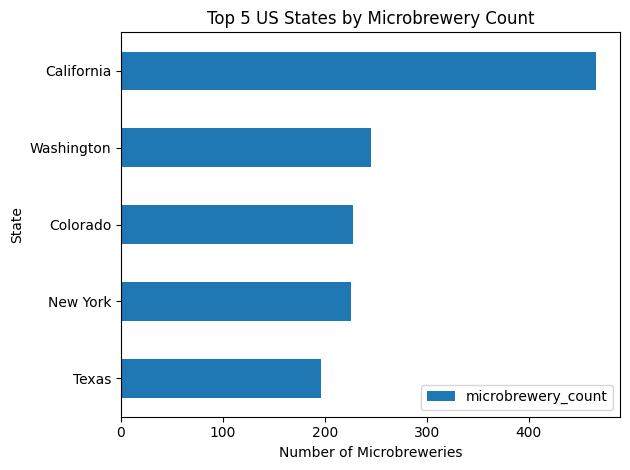

In [23]:
q2 = (us_micro.groupby("state_province")
      .size()
      .sort_values(ascending=False)
      .head(5)
      .reset_index(name="microbrewery_count"))

display(q2)

plt.figure()
q2.sort_values(by="microbrewery_count").plot(kind="barh", x="state_province", y="microbrewery_count")
plt.title("Top 5 US States by Microbrewery Count")
plt.xlabel("Number of Microbreweries")
plt.ylabel("State")
plt.tight_layout()
plt.show()

## Question 3: How many brewpub breweries are there in the state or province of Incheon, South Korea?

There are 2 brewpubs in Incheon, South Korea.


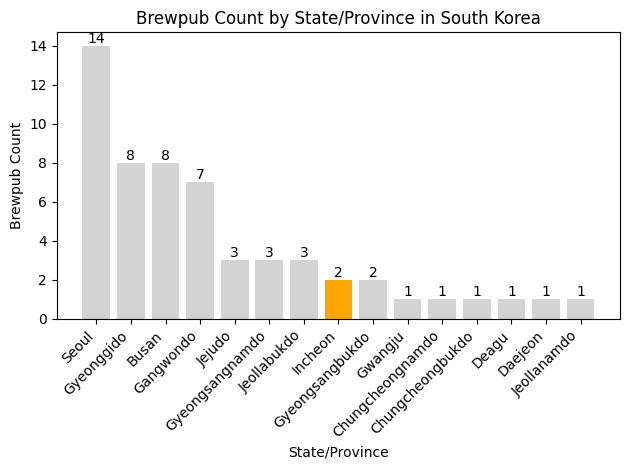

In [30]:
q3 = df[
    (df["country"] == "South Korea") &
    (df["state_province"] == "Incheon") &
    (df["type"] == "brewpub")
].shape[0]

print(f"There are {q3} brewpubs in Incheon, South Korea.")

# Additional visualization for brewpub counts by state/province in South Korea, just for fun

kr_brewpub = df[
    (df["country"] == "South Korea") &
    (df["type"] == "brewpub")
]

kr_counts = (kr_brewpub.groupby("state_province")
             .size()
             .sort_values(ascending=False))

# Create color list
colors = [
    "orange" if state == "Incheon" else "lightgray"
    for state in kr_counts.index
]

plt.figure()
bars = plt.bar(kr_counts.index, kr_counts.values, color=colors)

plt.title("Brewpub Count by State/Province in South Korea")
plt.xlabel("State/Province")
plt.ylabel("Brewpub Count")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(kr_counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()

## (Bonus + Optional) Question 4: How would you analyze the phone number patterns with cities in Korea based on the information given by the API?

In [52]:
# We take a peek at the data to see if we can find any patterns that we could use

korean_breweries = df[
    (df["country"] == "South Korea") &
    (df["phone"].notna())
].copy()

korean_breweries["phone"].head(10)

157      063-353-5515
2275    070-8872-1001
3547     02-6205-1785
9193    070-7799-2428
9194     051-611-9658
9195    070-8098-0621
9196     033-655-1357
9197    070-4837-6258
9198     064-733-5747
9199     031-572-6376
Name: phone, dtype: str

In [55]:
# Using the first dash to extract prefix as area code - Also according to this article https://en.wikipedia.org/wiki/Telephone_numbers_in_South_Korea the area code is the first part of the phone number and is 2 to 4 digits long, which is consistent with the format of the phone numbers in the dataset.
korean_breweries["area_code"] = korean_breweries["phone"].str.split("-").str[0]

# I divide between state and city as there are many cases where the same area code is shared between different cities in the same state, but not between different states. This way we can see if there are any patterns in the distribution of breweries by area code within states and cities.
area_code_by_state = (
    korean_breweries.groupby(["state_province", "area_code"])
    .size()
    .reset_index(name="count")
    .sort_values("area_code", ascending=True)
)

area_code_by_state.head(100)


,state_province,area_code,count
4,Chungcheongnamdo,010,1
23,Seoul,02,10
12,Gyeonggido,031,7
9,Gangwondo,033,5
5,Chungcheongnamdo,041,1
7,Daejeon,042,1
3,Chungcheongbukdo,043,1
13,Gyeonggido,050,1
0,Busan,050,1
8,Deagu,0507,1


In [56]:
area_code_by_city = (
    korean_breweries.groupby(["city", "area_code"])
    .size()
    .reset_index(name="count")
    .sort_values("area_code", ascending=True)
)

area_code_by_city.head(100)

,city,area_code,count
42,Seosan-si,010,1
40,Seongdong-gu,02,1
38,Seodaemun-gu,02,1
44,Songpa-gu,02,1
50,Yeongdeungpo-gu,02,1
30,Mapo-gu,02,2
18,Gwangjin-gu,02,1
37,Seocho-gu,02,1
9,Gangnam-gu,02,1
27,Jongno-gu,02,1


We see a ton of 070 area codes repeated, this is consistent with the wikipedia article that states: "070 - Internet phone (VoIP)".

We can assume that this is the relation between Phone number and City/State, the first 2 to 4 digits indicate procedence, if the area code does not correspond to one of the general codes like 010 (Mobile) and 070 (VoIP)